In [1]:
from datetime import datetime, timedelta
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from   sklearn.neighbors import KernelDensity
import yfinance as yf

sys.path.append('..')
from util.batcher import Batcher
#from util.stock_loader import Loader

In [2]:
SYMBOLS = [
    'AAPL', 'ABMD', 'ABNB', 'AMZN', 'ANET', 'APPH', 'ATVI', 'AXON', 
    'AYX', 'BILI', 'BROS', 'BYND', 'COUR','CPNG', 'DDOG', 'DOCU', 
    'DUOL', 'EDIT', 'ETSY', 'FSLY', 'FUV', 'GH', 'GMED', 'GOOG', 'INTG', 
    'ISRG', 'JD', 'LULU', 'LUV', 'MDB', 'MELI', 'MNST', 'MSFT', 'MTCH', 
    'NVCR', 'NVDA', 'OKTA', 'PANW', 'PINS', 'PTON', 'QDEL', 'RDFN', 
    'RGEN', 'ROKU', 'SE', 'SHOP', 'SPLK', 'TDOC', 'TEAM', 'TREX', 
    'TSLA', 'TTD', 'TTWO', 'TWLO', 'TWTR', 'UPST', 'VEEV', 'ZEN', 'ZG', 
    'ZNGA']
INDICES = ['^GSPC', # S&P 500
           '^IXIC', # Nasdaq
           '^NYA']  # NY Stock Exchange (total)
len(SYMBOLS)

60

In [3]:
TODAY = (datetime.now() + timedelta(1)).date()
START = TODAY - timedelta(5*365)
START, TODAY

(datetime.date(2016, 10, 10), datetime.date(2021, 10, 9))

In [4]:
batch = SYMBOLS + INDICES

In [5]:
data = yf.download(batch, start=START, end=TODAY).rename(columns={'Adj Close': 'AdjClose'})

[*********************100%***********************]  63 of 63 completed


In [6]:
def get_stock_data(stock, data):
    sub = data.loc[
        :,  
        [x for x in list(data) if x[1] == stock]]
    first_value = sub.AdjClose[stock][sub.AdjClose[stock].notna()].index[0]
    sub = sub.loc[first_value:, :]
    sub.columns = sub.columns.to_series().apply(lambda x: x[0])
    return sub

In [7]:
test = get_stock_data('DUOL', data)
test.head()

,AdjClose,Close,High,Low,Open,Volume
Date,,,,,,
2021-07-28,134.255005,134.255005,145.000000,130.000000,141.399994,2887900.0
2021-07-29,134.440002,134.440002,139.000000,132.000000,137.000000,693900.0
2021-07-30,140.250000,140.250000,141.399994,128.500000,135.179993,617700.0
2021-08-02,143.800003,143.800003,147.250000,134.720001,140.000000,586600.0
2021-08-03,139.860001,139.860001,146.990005,138.009995,143.160004,740100.0


In [8]:
def get_daily_returns(x):
    n = len(x)
    x = np.array(x)
    return x[2:n] / x[1:(n - 1)] - 1 

In [9]:
def get_sharpe(returns, window=None):
    n = len(returns)
    if window is None:
        window = n
    if len(returns) > window:
        returns = returns[(n - window):n]
    returns = returns[~np.isnan(returns)]
    sharpe = (np.sqrt(252) * returns.mean()) / returns.std()
    return sharpe

In [10]:
get_sharpe(get_daily_returns(test.AdjClose))

1.742330508274186

In [11]:
LMB = 0.9

In [12]:
def process_stock(stock, data, lmb=LMB, plot=False):
    stock_data = get_stock_data(stock, data)
    sharpe = get_sharpe(get_daily_returns(stock_data.AdjClose))
    stock_data.fillna(method='ffill', inplace=True)
    stock_data.fillna(method='bfill', inplace=True)
    n = stock_data.shape[0]
    WINDOW = min(n, 125)
    stock_data['ann_high'] = (stock_data.Close
                              .rolling(window=WINDOW)
                              .max())
    stock_data['ann_low'] = (stock_data.Close
                             .rolling(window=WINDOW)
                             .min())
    stock_data['drawdown'] = stock_data.Close / stock_data.ann_high
    stock_data['pullup'] = stock_data.Close / stock_data.ann_low
    w = [lmb ** t for t in range(n)][::-1]
    stock_data['W'] = w
    stock_data['n_samp'] = (stock_data.Volume / 100)  * stock_data.W
    stock_data['value'] = ((stock_data.Close 
                            + stock_data.High 
                            + stock_data.Low 
                            + stock_data.Open) 
                           / 4)
    stock_data['est'] = np.nan
    for day in stock_data.index:
        sub = stock_data[stock_data.index <= day]
        weights = sub.n_samp
        weights = weights / weights.sum()
        values = sub.value
        est = np.dot(weights, values)
        stock_data.loc[day, 'est'] = est
    stock_data['resid'] = stock_data.Close / stock_data.est
    stock_data.sort_values('resid', inplace=True)
    stock_data['dev'] = np.array(range(n)) / n
    stock_data.sort_index(inplace=True)
    if plot:
        plt.figure(figsize=(12, 8))
        plt.plot(stock_data.Close, label='Close')
        plt.plot(stock_data.est, label='Est')
        plt.yscale('log')
        plt.plot(stock_data.ann_high, color='green')
        plt.plot(stock_data.ann_low, color='red')
        plt.legend();
        plt.figure(figsize=(12, 4))
        plt.plot(stock_data.dev)
        plt.axhline(0.5, color='k')
        plt.title(stock)
        plt.figure(figsize=(12, 4))
        plt.plot(stock_data.drawdown, color='red', label='drawdown')
        plt.plot(stock_data.pullup, color='green', label='pullup')
        plt.plot(np.sqrt(stock_data.drawdown * stock_data.pullup),
                 color='grey',
                 label='geomean')
        plt.yscale('log')
        plt.legend()
    return (stock_data.resid.tolist()[-1], 
            stock_data.dev.tolist()[-1],
            stock_data.drawdown.tolist()[-1],
            stock_data.pullup.tolist()[-1],
            sharpe)

(0.9879110261965874,
 0.23272438443208895,
 0.8813344539057718,
 1.043363826190251,
 1.0839750329785616)

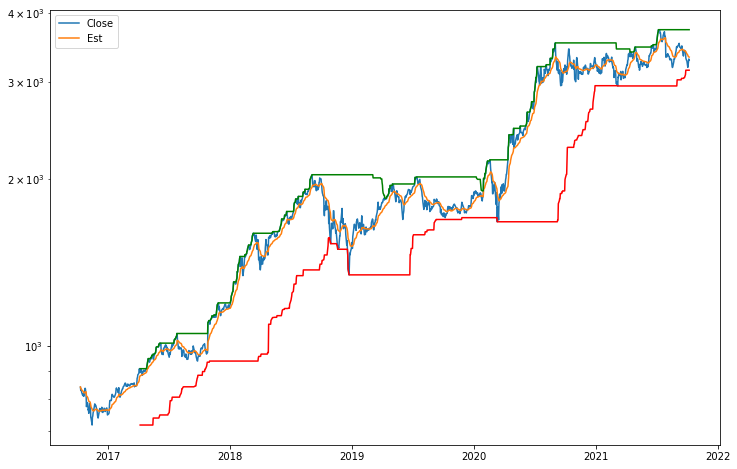

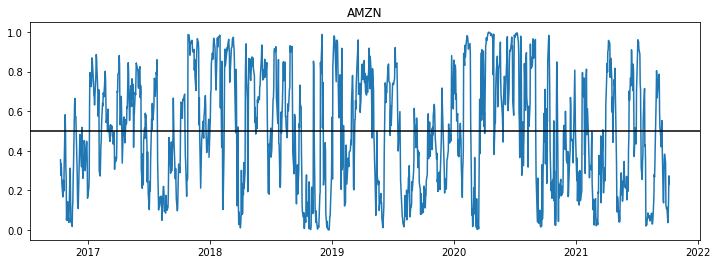

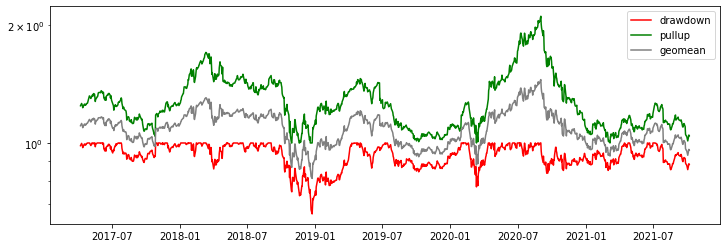

In [13]:
process_stock('AMZN', data.copy(), plot=True)

In [14]:
out = []
for stock in batch:
    print(f'{stock}...', end=' ')
    mult, dev, drop, climb, sharpe = process_stock(stock, data)
    out.append([stock, mult, dev, drop, climb, sharpe])

AAPL... ABMD... ABNB... AMZN... ANET... APPH... ATVI... AXON... AYX... BILI... BROS... BYND... COUR... CPNG... DDOG... DOCU... DUOL... EDIT... ETSY... FSLY... FUV... GH... GMED... GOOG... INTG... ISRG... JD... LULU... LUV... MDB... MELI... MNST... MSFT... MTCH... NVCR... NVDA... OKTA... PANW... PINS... PTON... QDEL... RDFN... RGEN... ROKU... SE... SHOP... SPLK... TDOC... TEAM... TREX... TSLA... TTD... TTWO... TWLO... TWTR... UPST... VEEV... ZEN... ZG... ZNGA... ^GSPC... ^IXIC... ^NYA... 

In [15]:
out = pd.DataFrame(
    data=out, 
    columns=['stock', 'fair_value_mult', 'dev_quantile', 'drop', 'climb', 'sharpe'])
out['geomean'] = np.sqrt(out['drop'] * out.climb)
out.loc
out['score'] = (out.fair_value_mult
                * out.dev_quantile
                * out['drop']
                * out.climb) ** (1/4) 
out = out[['stock', 'fair_value_mult', 'dev_quantile', 'drop', 'climb', 'geomean', 'score', 'sharpe']]
out.sort_values('score')

,stock,fair_value_mult,dev_quantile,drop,climb,geomean,score,sharpe
17,EDIT,0.774073,0.002383,0.488209,1.138063,0.745395,0.178921,0.618857
5,APPH,0.831868,0.056716,0.286497,1.000000,0.535254,0.340974,-0.017389
42,RGEN,0.899883,0.013503,0.798186,1.560137,1.115921,0.350727,1.263487
30,MELI,0.901371,0.019063,0.773450,1.165457,0.949433,0.352780,1.114675
34,NVCR,0.921867,0.113582,0.494281,1.018916,0.709670,0.479207,1.142661
...,...,...,...,...,...,...,...,...
4,ANET,1.041593,0.749801,0.973307,1.217255,1.088468,0.980774,0.927135
26,JD,1.055337,0.857824,0.944378,1.264030,1.092576,1.019584,0.722752
37,PANW,1.037671,0.758539,0.998197,1.521520,1.232387,1.045642,0.828583
52,TTWO,1.094363,0.994440,0.930067,1.195800,1.054597,1.048886,0.973374


In [16]:
out = out.sort_values('stock')
out.to_csv('../data/scoring.csv', index=False)
!open ../data/scoring.csv

In [17]:
try:
    historic = pd.read_csv('../data/historic.csv')
    historic = pd.concat([historic, out])
except FileNotFoundError:
    historic = out
    
print(historic.shape)

(1580, 8)


In [18]:
historic = historic[historic.score > 0]
historic.to_csv('../data/historic.csv', index=False)

In [19]:
historic.drop('stock', axis=1).quantile([0.004, 0.01, 0.05, 0.95, 0.99, 0.996])

,fair_value_mult,dev_quantile,drop,climb,geomean,score,sharpe
0.004,0.787222,0.007937,0.309262,1.000000,0.565696,0.259350,-1.527523
0.010,0.858935,0.021860,0.333004,1.000000,0.601871,0.347686,-1.398891
0.050,0.909209,0.053571,0.563855,1.000335,0.767869,0.441821,-0.009677
0.950,1.071444,0.793714,0.996290,1.943097,1.360298,1.079511,1.569655
0.990,1.188044,0.895675,1.000000,3.657908,1.840741,1.198879,2.240104
0.996,1.201306,0.935484,1.000000,3.934458,1.970546,1.344863,2.408164


In [20]:
1/250

0.004